In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, jit
import time
import sys
import os
from Code.EPRsimfcts import *
from qutip import Bloch


# Add both the Code directory and its parent to Python path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

for path in [current_dir, parent_dir]:
    if path not in sys.path:
        sys.path.insert(0, path)  # Insert at beginning of path
# Optional: Visualize the points

b = Bloch()

def Add_state(b, state):
    sx=np.array([[0, 1],[1, 0]])
    sy=np.array([[0, -1j],[1j, 0]])
    sz=np.array([[1, 0],[0, -1]])
    x=state.conj()@(sx@state)
    y=state.conj()@(sy@state)
    z=state.conj()@(sz@state)
    b.add_points([x.real, y.real, z.real])
    b.point_color = ['g']
    b.point_marker=['.']
    return b

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [11]:
def Rabi_frequency_v2(v1, v2, phi, theta, chi):
    C1=v1.conj()@(T1pS(np.exp(1j*chi)*(-1j*np.sin(phi)-np.cos(theta)*np.cos(phi))/np.sqrt(2))@v2)
    C2=v1.conj()@(T10S(np.exp(1j*chi)*(-np.sin(theta)*np.cos(phi))/np.sqrt(2))@v2)
    C3=v1.conj()@(T1mS(np.exp(-1j*chi)*(-1j*np.sin(phi)+np.cos(theta)*np.cos(phi))/np.sqrt(2))@v2)
    return C1+C2+C3

def Rabi_freq_Ave_over_phi_vs_orientation(B0, B1, theta, chi):
    phi=0
    H_1 = H0(2.356, 0.458, B0, phi, theta, chi)
    E_1, M1=np.linalg.eigh(H_1)
    Eigvec=M1.T #Here we may just inherit the eigen-state vectors from the main program to reduce the time of calculation
    #Note: we need to check if Tz and Tx/Ty energy curves have crossing so that we are not driving a wrong transition
    Txvec=Eigvec[2]
    Tzvec=Eigvec[0]
    Omega_squared_ave=0+0j
    C3=28024.9514242*B1*np.matmul(Txvec.conj(), np.matmul(T1mS(1), Tzvec))/np.sqrt(2)
    C2=-28024.9514242*B1*np.matmul(Txvec.conj(), np.matmul(T10S(1), Tzvec))
    C1=28024.9514242*B1*np.matmul(Txvec.conj(), np.matmul(T1pS(1), Tzvec))/np.sqrt(2)
    #print(C3, C2, C1)
    Omega_squared_ave=(np.abs(C1)**2+np.abs(C3)**2)*(1+np.cos(theta)**2)/2+\
                        np.sin(theta)**2/2*(np.abs(C2)**2+C1*np.conj(C3)*np.exp(2*1j*chi)+C3*np.conj(C1)*np.exp(-2*1j*chi))+\
                        np.sin(2*theta)/4*(-np.exp(1j*chi)*C1*np.conj(C2)-np.exp(-1j*chi)*C2*np.conj(C1)+np.exp(1j*chi)*C2*np.conj(C3)+np.exp(-1j*chi)*C3*np.conj(C2))
    #print(Omega_squared_ave)
    return np.sqrt(Omega_squared_ave)

@njit
def Eff_H(Omega: complex, delta: complex)-> complex:
    return np.array([[delta, Omega],[Omega.conjugate(), -delta]])/2

In [13]:
N_mol = 10001
#chi_01 = np.linspace(0, 2 * np.pi, N_mesh) 
phi_01=np.random.uniform(0, 2*np.pi, N_mol)
chi_01 = np.random.uniform(0, 2 * np.pi, N_mol)
cos_theta_01 = np.random.uniform(-1, 1, N_mol)   # Cosine of polar angle
#cos_theta_01 = np.linspace(-1, 1, N_mesh)
theta_01 = np.arccos(cos_theta_01) 
theta_12 = 0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = 0 # Set phi_12=0 for simplicity; but occasionally it is not)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2 # distance, unit: nm

#H0 and eigenvectors
D0 = 2.348 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=50*np.pi*2
gamma=28.02495142
Delta1 = np.zeros([N_mol])*(0+0j)
Delta2 = np.zeros([N_mol])*(0+0j)
Delta3 = np.zeros([N_mol])*(0+0j)
Rabi_freq=np.zeros([N_mol])*(0+0j)
Txz = np.zeros([N_mol])
Tyz = np.zeros([N_mol])
Txy = np.zeros([N_mol])
for i in range(N_mol):
    H_0 = H0(D0, E0, B0, 0.0, theta_01[i], chi_01[i])
    E_0, M0=np.linalg.eigh(H_0)
    Txz[i]=E_0[2]-E_0[0]
    Tyz[i]=E_0[1]-E_0[0]
    Txy[i]=E_0[2]-E_0[1]
        
    eigvec=M0.T
    Rabi_freq[i]=Omega1* Rabi_frequency_v2(eigvec[2], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
    #Rabi_freq[i]=Rabi_freq_Ave_over_phi_vs_orientation(B0, Omega1/28024.9514242, theta_01[i], chi_01[i])
        #print(E_0, M0)
        #Delta = [0, 0, 0]
    for q in [-1, 0, 1]:
        #for q in [0]:
        if q==-1:
            TS = T1mS(1)
        elif q==0:
            TS = T10S(1)
        elif q==1:
            TS = T1pS(1)
            #print (eigvec[0].conj())
        coef = C_q(q, theta_01[i], chi_01[i], theta_12, phi_12)
        Mat_prod1=np.matmul(eigvec[0].conj(), np.matmul(TS, eigvec[0]))
        Mat_prod2=np.matmul(eigvec[1].conj(), np.matmul(TS, eigvec[1]))
        Mat_prod3=np.matmul(eigvec[2].conj(), np.matmul(TS, eigvec[2]))
        #print(f"{theta_01[i]:.2f}", q, f"{coef:.4f}", f"{Mat_prod1:.4f}", f"{Mat_prod2:.4f}", f"{Mat_prod3:.4f}",)
        Delta1[i]=Delta1[i]+coef*Mat_prod1
        Delta2[i]=Delta2[i]+coef*Mat_prod2
        Delta3[i]=Delta3[i]+coef*Mat_prod3
        if np.abs(Delta1[i])<1e-10:
            Delta1[i]=0
        if np.abs(Delta2[i])<1e-10:
            Delta2[i]=0
        if np.abs(Delta3[i])<1e-10:
            Delta3[i]=0
        #print(f"{V/d**3*Delta1[i,j].real:.4f}", f"{V/d**3*Delta2[i, j].real:.4f}", f"{V/d**3*Delta3[i, j].real:.4f}")
deltaxz=Txz-np.mean(Txz)
deltayz=Tyz-np.mean(Tyz)
deltaxy=Txy-np.mean(Txy)   
Delta1= V/d**3*Delta1*2*np.pi
Delta2= V/d**3*Delta2*2*np.pi
Delta3= V/d**3*Delta3*2*np.pi
Omega_ave=np.mean(np.abs(Rabi_freq))

## Determine the Rabi frequency

In [666]:
# Define Pauli matrices and identity
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)
I2 = np.eye(2, dtype=complex)

def expm_hamiltonian(H, t):
    """
    Compute the time evolution operator U(t) = exp(-i H t) for a 2x2 Hermitian matrix H,
    using its decomposition into the identity and Pauli matrices.
    
    Parameters:
      H : 2x2 numpy array (Hermitian)
      t : time at which to evaluate U(t)
    
    Returns:
      U : 2x2 numpy array representing the time evolution operator at time t
    """
    # Decompose H = a0 * I + a_vec · sigma.
    # a0 is half the trace of H:
    a0 = 0.5 * np.trace(H)
    
    # Extract the coefficients for the Pauli matrices:
    # a_x = 0.5 * Re(H[0,1] + H[1,0])
    ax = 0.5 * (H[0, 1] + H[1, 0]).real
    # a_y = -0.5 * Im(H[0,1] - H[1,0])
    ay = -0.5 * (H[0, 1] - H[1, 0]).imag
    # a_z = 0.5 * (H[0,0] - H[1,1])
    az = 0.5 * (H[0, 0] - H[1, 1]).real
    a_vec = np.array([ax, ay, az])
    
    # Compute the norm of the vector part
    a_norm = np.linalg.norm(a_vec)
    
    # Overall phase factor from the trace part
    phase = np.exp(-1j * a0 * t)
    
    # If a_norm is nonzero, construct n_dot_sigma, otherwise just return phase*I.
    if a_norm > 1e-12:
        # Build the operator n·sigma using the Pauli matrices.
        n_dot_sigma = (ax * sx + ay * sy + az * sz) / a_norm
        U = phase * ( np.cos(a_norm * t) * I2 - 1j * np.sin(a_norm * t) * n_dot_sigma )
    else:
        U = phase * I2
        
    return U


Text(0, 0.5, 'Signal')

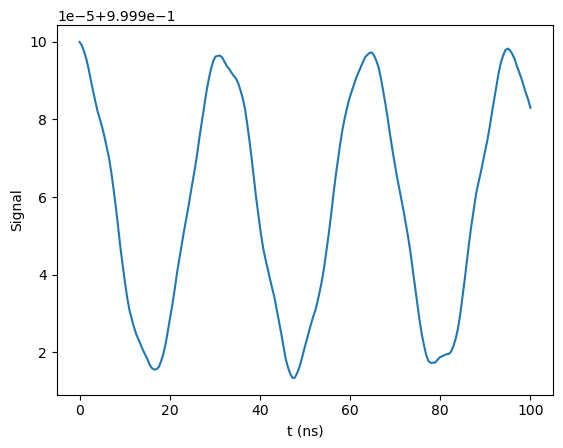

In [672]:
time_seq=np.linspace(0, 0.1, 200)
v0=np.array([1,0])*(1+0j)
sig=np.zeros([len(time_seq)])*(1+0j)
sz=np.array([[1, 0],[0, -1]])*(1+0j)
scale_factor=1 #Varying the mw poer

for n_i in range(N_mol):
    #H_mol=Eff_H(Rabi_freq_xz[n_i]*scale_factor, deltaxz[n_i]*np.pi*2*1000)
    H_mol=Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i]*np.pi*2*1000)
    U_0=expm_hamiltonian(H_mol, time_seq[1])
    for t_i in range(len(time_seq)):
        #U_mol=sp.linalg.expm(-1j*H_mol*time_seq[t_i])
        #U_mol=np.linalg.matrix_power(U_0, t_i)
        U_mol=expm_hamiltonian(H_mol, time_seq[t_i])
        v_i=U_mol@v0
        #print(U_mol.trace())
        sig[t_i]+=v_i.conj()@(sz@v_i)
plt.plot(time_seq*1000, np.real(sig)/N_mol)
plt.xlabel('t (ns)')
plt.ylabel('Signal')

In [682]:
np.argmin(sig[0:50])

np.int64(33)

In [684]:
time_seq[np.argmin(sig[0:50])]*1000 #Determine the pi pulse duration

np.float64(16.582914572864322)

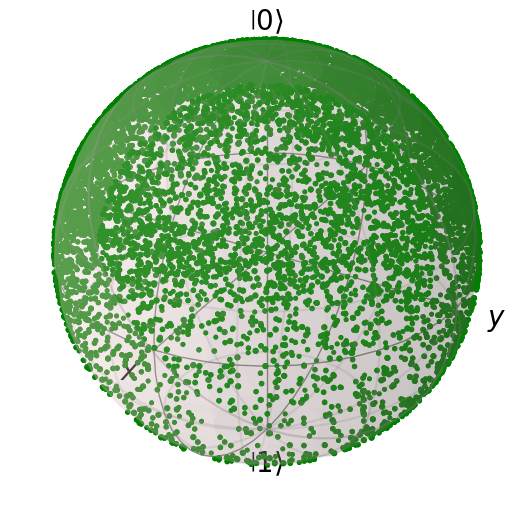

In [448]:
#Driving with a pi/2 pulse
v0=np.array([1,0])
t_pi=time_seq[np.argmin(sig)]
b=Bloch()
for i in range(N_mol):
    Hij=Eff_H(Rabi_freq[i], deltaxz[i]*np.pi*2*1000)
    Uij=expm_hamiltonian(Hij,t_pi/2)
    v1=Uij@v0
    Add_state(b, v1)
b.point_marker = ['.'] 
b.show()

## Spin-echo

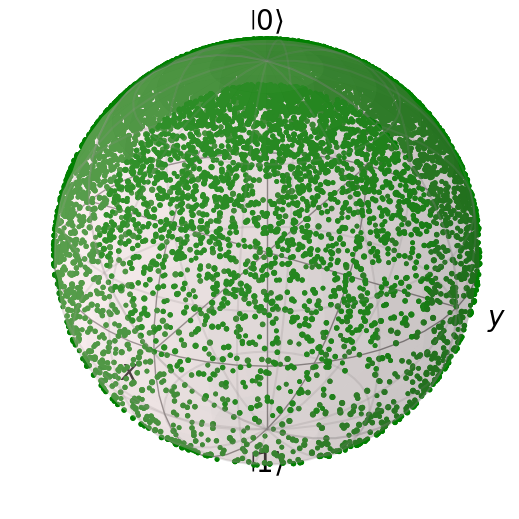

In [450]:
v0=np.array([1,0])
b=Bloch()
for i in range(N_mol):
    Hij=Eff_H(Rabi_freq[i], deltaxz[i]*np.pi*2*1000)
    Hij2=Eff_H(0, deltaxz[i]*np.pi*2*1000)
    Uij=expm_hamiltonian(Hij,t_pi/2)@expm_hamiltonian(Hij,0.05)@expm_hamiltonian(Hij,t_pi/2)
    #Note: scipy.linalg.expm(M) has issue when computing the exp of some complex 2-by-2 matrices here; reason is unknown yet
    v1=np.linalg.matrix_power(Uij, 2)@v0
    Add_state(b, v1)
b.show()

Text(0, 0.5, 'Signal')

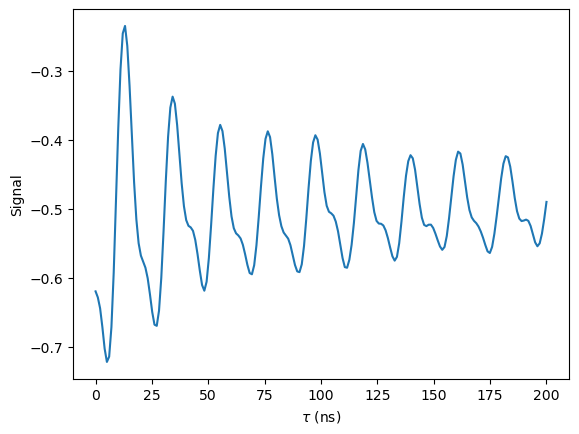

In [421]:
time_seq=np.linspace(0., 0.2, 200)
v0=np.array([0,1])
sig=np.zeros([len(time_seq)])*(0+0j)
sz=np.array([[1, 0],[0, -1]])*(1+0j)
single_signal=0+0j
scale_factor=1
t_tot=np.zeros_like(time_seq)
for n_i in range(N_mol):
    #H_mol=Eff_H(Rabi_freq[n_i], deltaxz[n_i]*np.pi*2*1000)
    Hij=Eff_H(Rabi_freq[n_i]*scale_factor, deltaxz[n_i]*np.pi*2*1000)
    Hij2=Eff_H(0, deltaxz[n_i]*np.pi*2*1000)
    for t_i in range(len(time_seq)):
        U_mol=expm_hamiltonian(Hij,t_pi/2/scale_factor)@(expm_hamiltonian(Hij2,time_seq[t_i])@expm_hamiltonian(Hij,t_pi/2/scale_factor))
        v_i=(np.linalg.matrix_power(U_mol, 2))@v0
        single_signal=v_i.conj()@(sz@v_i)
        #print(single_signal)
        sig[t_i]+=v_i.conj()@(sz@v_i)
        #t_tot[t_i]=240*time_seq[t_i]+239*t_pi

plt.plot(time_seq*1000, np.real(sig)/N_mol)
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel('Signal')

(-1.0, 1.0)

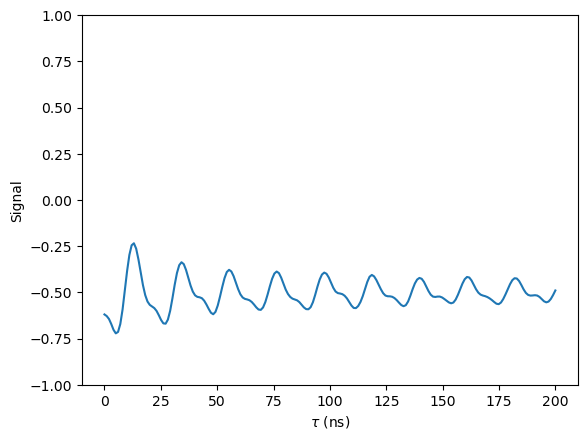

In [422]:
plt.plot(time_seq*1000, np.real(sig)/N_mol)
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel('Signal')
plt.ylim([-1, 1])

Text(0.5, 0, 'FFT frequency (MHz)')

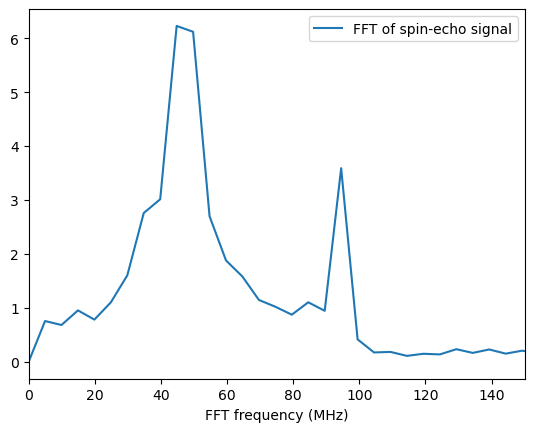

In [423]:
sig_rfft = np.fft.rfft(sig-np.mean(sig))/N_mol
freq = np.fft.rfftfreq(len(time_seq), d=time_seq[1]-time_seq[0])
plt.plot(freq,np.abs(sig_rfft), label=r"FFT of spin-echo signal")
plt.xlim([0, 150])
#plt.ylim([0, 4])
plt.legend()
plt.xlabel(r"FFT frequency (MHz)")

## CPMG sequence

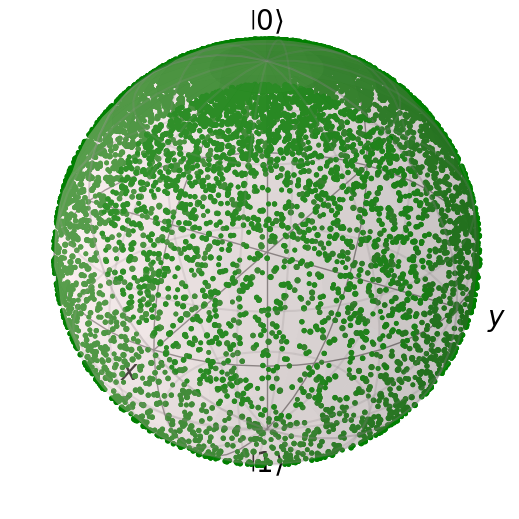

In [425]:
#CPMG sequence with 240 pi pulses
v0=np.array([1,0])
b=Bloch()
for i in range(N_mol):
    Hij=Eff_H(Rabi_freq[i], deltaxz[i]*np.pi*2*1000)
    Hij2=Eff_H(0, deltaxz[i]*np.pi*2*1000)
    M=expm_hamiltonian(Hij,t_pi/2)@(expm_hamiltonian(Hij2,0.166)@expm_hamiltonian(Hij,t_pi/2))
    Uij=np.linalg.matrix_power(M, 240)
    v1=Uij@v0
    Add_state(b, v1)
b.show()

Text(0, 0.5, 'Signal')

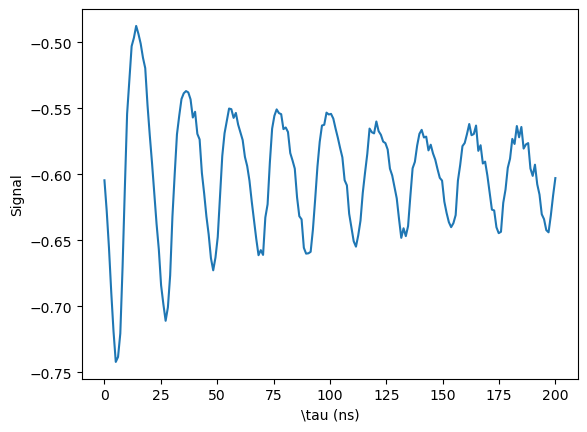

In [426]:
time_seq=np.linspace(0., 0.2, 200)
v0=np.array([0,1])
sig=np.zeros([len(time_seq)])*(0+0j)
sz=np.array([[1, 0],[0, -1]])*(1+0j)
single_signal=0+0j
t_tot=np.zeros_like(time_seq)
for n_i in range(N_mol):
    #H_mol=Eff_H(Rabi_freq[n_i], deltaxz[n_i]*np.pi*2*1000)
    Hij=Eff_H(Rabi_freq[n_i], deltaxz[n_i]*np.pi*2*1000)
    Hij2=Eff_H(0, deltaxz[n_i]*np.pi*2*1000)
    for t_i in range(len(time_seq)):
        U_mol=expm_hamiltonian(Hij,t_pi/2)@(expm_hamiltonian(Hij2,time_seq[t_i])@expm_hamiltonian(Hij,t_pi/2))
        v_i=(np.linalg.matrix_power(U_mol, 240))@v0
        single_signal=v_i.conj()@(sz@v_i)
        #print(single_signal)
        sig[t_i]+=v_i.conj()@(sz@v_i)
        t_tot[t_i]=240*time_seq[t_i]+239*t_pi

plt.plot(time_seq*1000, np.real(sig)/N_mol)
plt.xlabel(r'\tau (ns)')
plt.ylabel('Signal')

Text(0, 0.5, 'Signal')

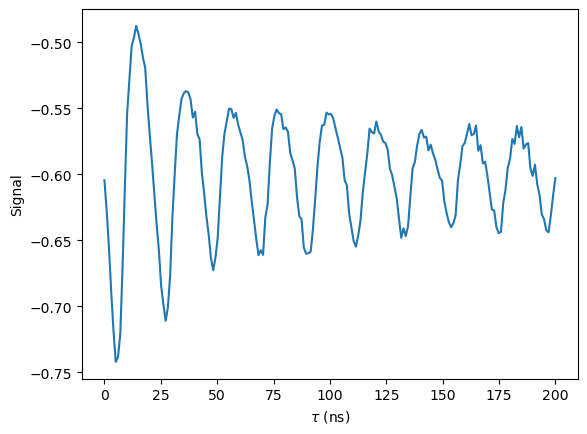

In [427]:
plt.plot(time_seq*1000, np.real(sig)/N_mol)
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel('Signal')

(-1.0, 1.0)

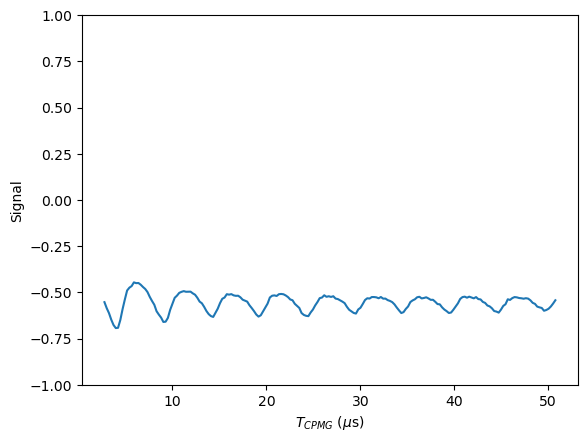

In [388]:
plt.plot(t_tot, np.real(sig)/N_mol)
plt.xlabel(r'$T_{CPMG}$ ($\mu$s)')
plt.ylabel('Signal')
plt.ylim([-1, 1])

## spin-spin coupling strength calculation

In [19]:
#Plotting the strength of dipole-dipole interaction vs. the orientation of EYFP in lab frame
N_mesh = 100
chi_01 = np.linspace(0, 2 * np.pi, N_mesh) 
#cos_theta_01 = np.random.uniform(-1, 1)   # Cosine of polar angle
cos_theta_01 = np.linspace(-1, 1, N_mesh)
theta_01 = np.arccos(cos_theta_01) 
theta_12 = np.pi/2*0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = np.pi/3*0 # Set phi_12=0 for simplicity; but occasionally it is not)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2 # distance, unit: nm

In [21]:
D0 = 2.348 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Delta1 = np.zeros([N_mesh, N_mesh])*(0+0j)
Delta2 = np.zeros([N_mesh, N_mesh])*(0+0j)
Delta3 = np.zeros([N_mesh, N_mesh])*(0+0j)
Txz = np.zeros([N_mesh, N_mesh])
Tyz = np.zeros([N_mesh, N_mesh])
Txy = np.zeros([N_mesh, N_mesh])
for i in range(N_mesh):
    for j in range(N_mesh):
        H_0 = H0(D0, E0, B0, 0.0, theta_01[i], chi_01[j])
        E_0, M0=np.linalg.eigh(H_0)
        Txz[i, j]=E_0[2]-E_0[0]
        Tyz[i, j]=E_0[1]-E_0[0]
        Txy[i, j]=E_0[2]-E_0[1]
        eigvec=M0.T
        #print(E_0, M0)
        #Delta = [0, 0, 0]
        for q in [-1, 0, 1]:
        #for q in [0]:
            if q==-1:
                TS = T1mS(1)
            elif q==0:
                TS = T10S(1)
            elif q==1:
                TS = T1pS(1)
            #print (eigvec[0].conj())
            coef = C_q(q, theta_01[i], chi_01[j], theta_12, phi_12)
            Mat_prod1=eigvec[0].conj()@np.matmul(TS, eigvec[0])
            Mat_prod2=eigvec[1].conj()@np.matmul(TS, eigvec[1])
            Mat_prod3=eigvec[2].conj()@np.matmul(TS, eigvec[2])
            #print(f"{theta_01[i]:.2f}", q, f"{coef:.4f}", f"{Mat_prod1:.4f}", f"{Mat_prod2:.4f}", f"{Mat_prod3:.4f}",)
            Delta1[i, j]=Delta1[i, j]+coef*Mat_prod1
            Delta2[i,j]=Delta2[i,j]+coef*Mat_prod2
            Delta3[i,j]=Delta3[i,j]+coef*Mat_prod3
        if np.abs(Delta1[i,j])<1e-10:
            Delta1[i,j]=0
        if np.abs(Delta2[i,j])<1e-10:
            Delta2[i,j]=0
        if np.abs(Delta3[i,j])<1e-10:
            Delta3[i,j]=0
        #print(f"{V/d**3*Delta1[i,j].real:.4f}", f"{V/d**3*Delta2[i, j].real:.4f}", f"{V/d**3*Delta3[i, j].real:.4f}")
            
Delta1= V/d**3*Delta1
Delta2= V/d**3*Delta2
Delta3= V/d**3*Delta3

Text(0.5, 0, '$\\Delta_x$ (MHz)')

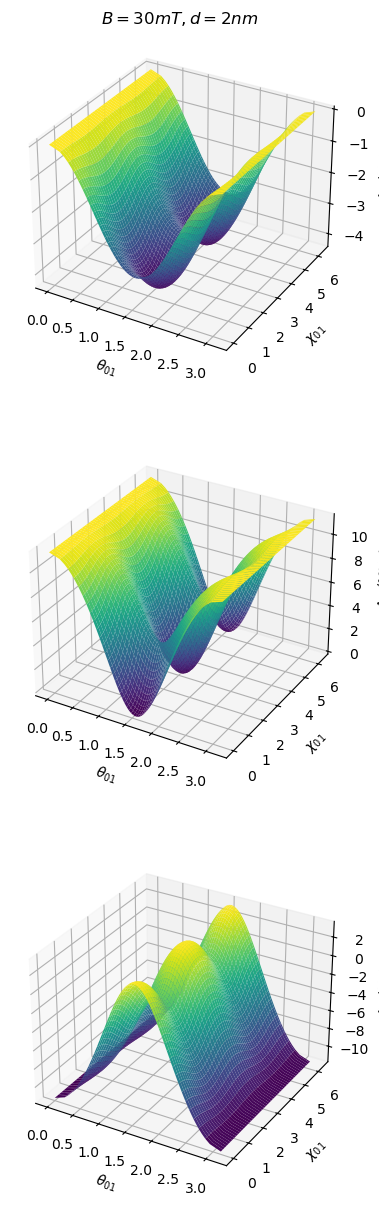

In [22]:
fig = plt.figure(figsize=(10,15))  # Create a figure
ax1 = fig.add_subplot(311, projection='3d')  # Add 3D axes
ax2 = fig.add_subplot(312, projection='3d')  # Add 3D axes
ax3 = fig.add_subplot(313, projection='3d')  # Add 3D axes
x,y = np.meshgrid(theta_01, chi_01)
#ax1.set_title(r'$B=0mT, d = 2nm, \theta=0, \phi=0$')
ax1.set_title(r'$B=30mT, d = 2nm$')
ax1.plot_surface(x,y, (Delta1.T).real*1000, cmap='viridis')
ax1.set_xlabel(r'$\theta_{01}$')
ax1.set_ylabel(r'$\chi_{01}$')
ax1.set_zlabel(r'$\Delta_z$ (MHz)')
#ax1.set_zlim([-1, 1])
ax2.plot_surface(x,y, (Delta2.T).real*1000, cmap='viridis')
ax2.set_xlabel(r'$\theta_{01}$')
ax2.set_ylabel(r'$\chi_{01}$')
ax2.set_zlabel(r'$\Delta_y$ (MHz)')
#ax2.set_zlim([-1, 1])
ax3.plot_surface(x,y, (Delta3.T).real*1000, cmap='viridis')
ax3.set_xlabel(r'$\theta_{01}$')
ax3.set_ylabel(r'$\chi_{01}$')
ax3.set_zlabel(r'$\Delta_x$ (MHz)')
#ax3.set_zlim([-1, 1])
#ax1.legend()

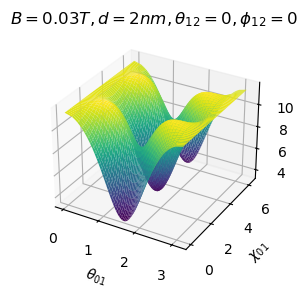

In [23]:
fig = plt.figure(figsize=(3,4))  # Create a figure
ax1 = fig.add_subplot(111, projection='3d')  # Add 3D axes
x, y = np.meshgrid(theta_01, chi_01)
ax1.set_title(r'$B=0.03T, d = 2nm, \theta_{12}=0, \phi_{12}=0$')
ax1.plot_surface(x,y, ((Delta2.T).real*1000-(Delta1.T).real*1000), cmap='viridis')
ax1.set_xlabel(r'$\theta_{01}$')
ax1.set_ylabel(r'$\chi_{01}$')
ax1.set_zlabel(r'$\Delta_y$ (MHz)', labelpad=20)
ax1.zaxis.label.set_position((3, 6, 0))

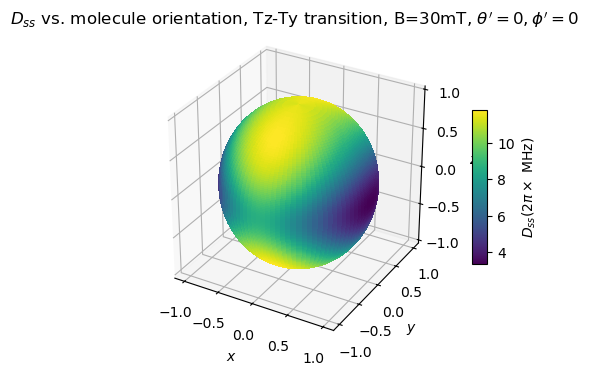

In [25]:
from matplotlib.cm import ScalarMappable

# Step 1: Define the grid in spherical coordinates
theta, chi = np.meshgrid(theta_01, chi_01)

# Step 2: Compute Cartesian coordinates for the unit sphere
x = np.sin(theta) * np.cos(chi)
y = np.sin(theta) * np.sin(chi)
z = np.cos(theta)
F = ((Delta2.T).real*1000-(Delta1.T).real*1000).real
F_norm = (F - F.min()) / (F.max() - F.min())
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
#x,y,z=np.sin(theta_01)*np.cos(chi_01), np.sin(theta_01)*np.sin(chi_01), np.cos(theta_01), 
# Plot the surface and use the colormap to set face colors based on F_norm
surf = ax.plot_surface(
    x, y, z, 
    facecolors=plt.cm.viridis(F_norm), 
    rstride=1, cstride=1, 
    linewidth=0, antialiased=False, shade=False
)

# Step 4: Add a colorbar
mappable = ScalarMappable(cmap='viridis')
mappable.set_array(F)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label=r'$D_{ss} (2\pi\times$ MHz)')

# Setting labels and title
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_box_aspect([1,1,1])  # Ensure equal scaling

plt.title(r"$D_{ss}$ vs. molecule orientation, Tz-Ty transition, B=30mT, $\theta'=0, \phi'=0$")
plt.show()

## Simulation for DEER signal

In [381]:
import scipy as sp
#@njit
#@jit(forceobj=True)
def matrix_exponential_diag(A):
    """
    Compute the matrix exponential e^A using the diagonalization method.
    
    This function assumes that the square matrix A is diagonalizable.
    
    Parameters:
        A (np.ndarray): A square matrix (n x n).
        
    Returns:
        expA (np.ndarray): The matrix exponential e^A.
    """
    # Compute eigenvalues and eigenvectors of A.
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    # Compute the diagonal matrix of the exponentials of the eigenvalues.
    exp_lambda = np.diag(np.exp(eigenvalues))
    
    # Compute the matrix exponential using the formula e^A = V exp(Λ) V^{-1}
    expA = eigenvectors @ exp_lambda @ np.linalg.inv(eigenvectors)
    #expA = eigenvectors @ exp_lambda @ eigenvectors.conj().T
    return expA
@njit
def matmul_numba(a, b):
    n, m = a.shape
    p = b.shape[1]
    result = np.zeros((n, p), dtype=np.complex128)
    for i in range(n):
        for j in range(p):
            for k in range(m):
                result[i, j] += a[i, k] * b[k, j]
    return result


@njit
def matrix_exponential_diag_numba(A):
    # Compute eigenvalues and eigenvectors of A.
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    # Compute the diagonal matrix of the exponentials of the eigenvalues.
    exp_lambda = np.diag(np.exp(eigenvalues))
    
    # Compute the matrix exponential using the formula e^A = V exp(Λ) V^{-1}
    expA = matmul_numba(eigenvectors, matmul_numba(exp_lambda, np.linalg.inv(eigenvectors)))
    #expA = eigenvectors @ exp_lambda @ eigenvectors.conj().T
    return expA    
#Define all the time-evolution operators; 
#functions labelled with t are using analytical formula for the exponential of matrix
@njit
def U_0t(delta1, Dss, t):
    theta=delta1*t/2
    gamma=Dss*t/4
    return np.array([[np.exp(-1j*theta-1j*gamma), 0, 0, 0],
                     [0, np.exp(1j*theta+1j*gamma), 0, 0],
                     [0, 0, np.exp(-1j*theta+1j*gamma), 0],
                     [0, 0, 0, np.exp(1j*theta-1j*gamma)]])

@njit
def U_1t(Omega1, delta1, Dss, t): #time-evolution operator for EYFP MW transition is being addressed
    #Already checked with diagonalization method, this function is correct
    delta_p = delta1+Dss/2
    delta_m = delta1-Dss/2
    Omega_p=np.sqrt(Omega1**2+delta_p**2)
    Omega_m=np.sqrt(Omega1**2+delta_m**2)
    theta_p=Omega_p*t/2
    theta_m=Omega_m*t/2
    M11 = np.cos(theta_p) - 1j*delta_p/Omega_p*np.sin(theta_p)
    M12 = -1j*Omega1*np.sin(theta_p)/Omega_p
    M22 = np.cos(theta_p)+1j*delta_p/Omega_p*np.sin(theta_p)
    M33 = np.cos(theta_m)-1j*delta_m/Omega_m*np.sin(theta_m)
    M34 = -1j*Omega1*np.sin(theta_m)/Omega_m
    M44 = np.cos(theta_m)+1j*delta_m/Omega_m*np.sin(theta_m)
    U = np.array([[M11, M12, 0, 0],
                  [M12, M22, 0, 0],
                  [0, 0, M33, M34],
                  [0, 0, M34, M44]])
    #np.cos(Omega_p*t/2)*I-1j*(delta_p*sigmaz+Omega*sigmax)/Omega_p*np.sin(Omega_p*t/2)
    #U_m = np.cos(Omega_m*t/2)*I-1j*(delta_m*sigmaz+Omega*sigmax)/Omega_m*np.sin(Omega_m*t/2)
    return U

@njit
def U_1(Omega1: complex, delta1:float, Dss:complex, t:float): #time-evolution operator for target spin MW transition is being addressed
    #DO NOT USE scipy, the scipy function sucks
    H0=np.array([[(delta1+Dss/2)/2, Omega1/2, 0,  0],
                 [np.conj(Omega1)/2, (-delta1-Dss/2)/2, 0, 0],
                 [0, 0, (delta1-Dss/2)/2,  Omega1/2],
                 [0, 0, np.conj(Omega1)/2, (-delta1+Dss/2)/2]])
    #print(np.linalg.eigh(H0))
    #print(H0)
    #U=sp.linalg.expm(-1j*H0*t)
    U=matrix_exponential_diag_numba(-1j*H0*t)
    return U

@njit
def U_2_pi_pulse(Omega2, delta1, Dss): #time-evolution operator for pi pulse on target spin is being addressed
    Omega_p=np.sqrt(Omega2**2+Dss**2/4)
    C1=1j*Dss/(2*Omega_p)
    C2=1j*Omega2/Omega_p
    C3=np.exp(1j*delta1*np.pi/(2*Omega_p))
    C4=np.exp(-1j*delta1*np.pi/(2*Omega_p))
    U=np.array([[-C1*C4, 0, -C2*C4, 0],[0, C1*C3, 0, -C2*C3],[-C2*C4, 0, C1*C4, 0],[0, -C2*C3, 0, -C1*C3]])
    return U

@njit
def U_2(Omega2:float, delta1: complex, Dss: complex, t:float): #time-evolution operator for target spin MW transition is being addressed
    #This function using the custom matrix exponential method
    H0=np.array([[(delta1+Dss/2)/2, 0, Omega2/2, 0],
                 [0, (-delta1-Dss/2)/2, 0, Omega2/2],
                 [Omega2/2, 0, (delta1-Dss/2)/2, 0],
                 [0, Omega2/2, 0, (-delta1+Dss/2)/2]])
    #print(np.linalg.eigh(H0))

    #U=sp.linalg.expm(-1j*H0*t)
    U=matrix_exponential_diag_numba(-1j*H0*t)
    return U

@njit
def U_3(Omega1: complex, Omega2:float, delta1: complex, Dss: complex, t:float): #time-evolution operator for both transitions are being addressed
    H0=np.array([[(delta1+Dss/2)/2, Omega1/2, Omega2/2, 0],
                 [np.conj(Omega1)/2, (-delta1-Dss/2)/2, 0, Omega2/2],
                 [Omega2/2, 0, (delta1-Dss/2)/2, Omega1/2],
                 [0, Omega2/2, np.conj(Omega1)/2, (-delta1+Dss/2)/2]])
    #print(np.linalg.eigh(H0))
    #U=sp.linalg.expm(-1j*H0*t)
    U=matrix_exponential_diag_numba(-1j*H0*t)
    return U




In [283]:
#Defining and obtaining all the parameters needed for simulation of DEER
@njit
def Generate_molecule_set(Number_of_molecules):
    phi_01=np.random.uniform(0, 2*np.pi, Number_of_molecules) # The first Euler angle
    chi_01 = np.random.uniform(0, 2 * np.pi, Number_of_molecules) # The third Euler angle
    cos_theta_01 = np.random.uniform(-1, 1, Number_of_molecules)   # Cosine of polar angle
    theta_01 = np.arccos(cos_theta_01) # The second Euler angle
    return phi_01, theta_01, chi_01
    
def Transitions_and_couplings_calculation(B0, D0, E0, d, Omega1, t_pi, phi_01, theta_01, chi_01, theta_12, phi_12):
    #B0: magnetic field, D0, E0: ZFS, d: distance, Omega1: \gamma_B B_1, the Rabi frequency factor, 
    #t_pi: pi pulse duration, phi_01, theta_01, chi_01: Euler angles between Lab frame and D-tensor frame, theta_12, phi_12: inter-spin vector orientation in D-tensor frame
    N_mol=len(theta_01)
    Delta1 = np.zeros(N_mol)*(0+0j)
    Delta2 = np.zeros(N_mol)*(0+0j)
    Delta3 = np.zeros(N_mol)*(0+0j)
    nx = np.zeros(N_mol)
    ny = np.zeros(N_mol)
    nz = np.zeros(N_mol)
    Rabi_freq_xz = np.zeros(N_mol)*(0+0j)
    Rabi_freq_yz = np.zeros(N_mol)*(0+0j)
    Txz = np.zeros(N_mol)*(0+0j)
    Tyz = np.zeros(N_mol)*(0+0j)
    Txy = np.zeros(N_mol)*(0+0j)   
    E_1, M1=np.linalg.eigh(H0(D0, E0, 0, 0.0, 0.0, 0.0)) 
    nx0=0.4
    ny0=0.4
    nz0=0.2
    for i in range(N_mol):
        H_0 = H0(D0, E0, B0, 0.0, theta_01[i], phi_01[i])
        E_0, M0=np.linalg.eigh(H_0)
        Txz[i]=E_0[2]-E_0[0]
        Tyz[i]=E_0[1]-E_0[0]
        Txy[i]=E_0[2]-E_0[1]
        eigvec=M0.T
        Rabi_freq_xz[i]=Omega1 * Rabi_frequency_v2(eigvec[2], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
        Rabi_freq_yz[i]=Omega1 * Rabi_frequency_v2(eigvec[1], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
        nx[i]=nx0*np.abs(np.matmul(M1.T[2], M0.T[2]))**2+ny0*np.abs(np.matmul(M1.T[1], M0.T[2]))**2+nz0*np.abs(np.matmul(M1.T[0], M0.T[2]))**2
        ny[i]=nx0*np.abs(np.matmul(M1.T[2], M0.T[1]))**2+ny0*np.abs(np.matmul(M1.T[1], M0.T[1]))**2+nz0*np.abs(np.matmul(M1.T[0], M0.T[1]))**2
        nz[i]=nx0*np.abs(np.matmul(M1.T[2], M0.T[0]))**2+ny0*np.abs(np.matmul(M1.T[1], M0.T[0]))**2+nz0*np.abs(np.matmul(M1.T[0], M0.T[0]))**2
        for q in [-1, 0, 1]:
            if q==-1:
                TS = T1mS(1)
            elif q==0:
                TS = T10S(1)
            elif q==1:
                TS = T1pS(1)
                #print (eigvec[0].conj())
            Delta1[i]+=C_q(q, theta_01[i], chi_01[i], theta_12, phi_12)*(eigvec[0].conj()@(TS@eigvec[0]))
            Delta2[i]+=C_q(q, theta_01[i], chi_01[i], theta_12, phi_12)*(eigvec[1].conj()@(TS@eigvec[1]))
            Delta3[i]+=C_q(q, theta_01[i], chi_01[i], theta_12, phi_12)*(eigvec[2].conj()@(TS@eigvec[2]))

    Delta1= V/d**3*Delta1 #Dipole coupling strength of Tz state
    Delta2= V/d**3*Delta2 #Dipole coupling strength of Ty state
    Delta3= V/d**3*Delta3 #Dipole coupling strength of Tx state
    Txz_ave = np.mean(Txz)
    Tyz_ave=np.mean(Tyz)
    Dss_zx=(Delta3-Delta1)*1000*2*np.pi # Dipole coupling strength Dss for Tz-Tx transition, unit: MHz
    Dss_zy=(Delta2-Delta1)*1000*2*np.pi # Dipole coupling strength Dss for Tz-Ty transition, unit: MHz
    deltaxz=(Txz-Txz_ave)*1000*2*np.pi #Tz-Tx transition detuning
    deltayz=(Tyz-Tyz_ave)*1000*2*np.pi #Tz-Ty transition detuning
    return Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz

In [574]:
    
N_mol = 20001 #Total molecule number
phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)

theta_12 = 0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = 0 # Set phi_12=0 for simplicity; but generally it is not)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
t_pi=0.011055 #pi pulse duration, unit: us, the value is defined from the Rabi oscillation part of this jupyter notebook

Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation(B0, D0, E0, d, Omega1, t_pi, phi_01, theta_01, chi_01, theta_12, phi_12)

### 4-pulse DEER on $T_z$ to $T_x$ transition

In [793]:
#Defining time sequences
from numba import prange, set_num_threads, get_num_threads
set_num_threads(2)

N_tau=51 #Time sequence resolution
tau_eyfp_1=0.05 # fix the tau value for EFYP in the 4-pulse DEER simulation, unit: us
tau_eyfp_2=0.5

@njit(parallel=True)
def DEER_4_pulse_numba(Rabi_freq: complex, t_pi: float, Omega1: float, delta: float, Dss:complex, tau1: float, tau2: float, N_tau:int, n_g:float, n_e:float): #n_g, n_e: population on ground/excited states
    #Numba version of the 4-pulse DEER simulation
    tau_total=tau1+tau2
    tau=np.linspace(0, tau_total, N_tau)
    #print('definition-0')
    sig_p=np.zeros_like(tau) #coupling to spin up
    sig_m=np.zeros_like(tau) #coupling to spin down
    sig_c=np.zeros_like(tau) #no coupling, for comparison only
    rho_0p = np.zeros((4, 4), dtype=np.complex128)
    rho_0m = np.zeros((4, 4), dtype=np.complex128)
    Dssi=0.0+0.0j
    N_mol=len(Rabi_freq)

    O_s = np.array([[1/2,0, 0, 0], [0,-1/2, 0, 0],[0,0, 1/2, 0],[0,0, 0, -1/2]]) #Observation operator for EYFP spin
    #print('definition-1')
    for j in range(N_tau):
        for i in range(N_mol):
            #print('Start of the (', i, ', ', j, ')th for-loops')
            rho_0p[0, 0] = n_g[i]
            rho_0p[1, 1] = n_e[i]
            rho_0p[2, 2] = 0.0
            rho_0p[3, 3] = 0.0

            rho_0m[0, 0] = 0.0
            rho_0m[1, 1] = 0.0
            rho_0m[2, 2] = n_g[i]
            rho_0m[3, 3] = n_e[i]
            delta_1 = delta[i] #detuning delta_1 for eYFP MW pumping, unit: MHz
            Dssi = Dss[i] #Unit: MHz
            #print('Definition of rhos in the (', i, ', ', j, ')th for-loops')
            #Pulse sequence
            U1=U_1t(np.abs(Rabi_freq[i]), delta_1, Dssi, t_pi/2) #pi/2 pulse on EYFP
            U_fe_1= U_0t(delta_1, Dssi, tau1) #'fe' means free evolution
            U2=matmul_numba(U1,U1) # pi pulse on EYFP
            U_fe_2= U_0t(delta_1, Dssi, tau[j])
            U3=U_2_pi_pulse(Omega1, delta_1, Dssi) #the third pi pulse, applied to the target spin
            U_fe_3= U_0t(delta_1, Dssi, tau_total-tau[j])
            U_fe_4= U_0t(delta_1, Dssi, tau2)
            U_DEER_4=matmul_numba(U1, matmul_numba(U_fe_4, matmul_numba(U2, matmul_numba(U_fe_3, matmul_numba(U3, matmul_numba(U_fe_2, matmul_numba(U2,matmul_numba(U_fe_1,U1)))))))) #4-pulse DEER sequence
            #print('Definition of Us in the (', i, ', ', j, ')th for-loops')        
            #U10=U_1t(Rabi_freq[i], delta_1, 0, t_pi/2)
            #U_fe_10= U_0t(delta_1, 0, tau1)
            #U20=matmul_numba(U10,U10) # pi pulse on EYFP
            #U_fe_20= U_0t(delta_1, 0, tau[j])
            #U30=U_2_pi_pulse(Omega1, delta_1, 0) #the third pi pulse, applied to the target spin
            #U_fe_30= U_0t(delta_1, 0, tau_total-tau[j])
            #U_fe_40= U_0t(delta_1, 0, tau2)
            #U_SE = matmul_numba(U10, matmul_numba(U_fe_40, matmul_numba(U20, matmul_numba(U_fe_30, matmul_numba(U30, matmul_numba(U_fe_20, matmul_numba(U20, matmul_numba(U_fe_10,U10))))))))

            
            rho_tp =matmul_numba(U_DEER_4, matmul_numba(rho_0p, np.conj(U_DEER_4).T))
            rho_tm =matmul_numba(U_DEER_4, matmul_numba(rho_0m, np.conj(U_DEER_4).T))
            #rho_t0 =matmul_numba(U_SE, matmul_numba(rho_0p, np.conj(U_SE).T))
            sig_p[j]+=np.trace(matmul_numba(rho_tp, O_s)).real
            sig_m[j]+=np.trace(matmul_numba(rho_tm, O_s)).real
            #sig_c[j]+=np.trace(matmul_numba(rho_t0, O_s)).real
    sig_p=sig_p/N_mol
    sig_m=sig_m/N_mol
    #sig_c=sig_c/N_mol
    return tau, sig_p, sig_m, sig_c


def DEER_4_pulse(Rabi_freq, Omega1, delta, Dss, tau1, tau2, N_tau, n_g, n_e): #n_g, n_e: population on ground/excited states
    tau_total=tau1+tau2
    tau=np.linspace(0, tau_total, N_tau)
    sig_p=np.zeros_like(tau) #coupling to spin up
    sig_m=np.zeros_like(tau) #coupling to spin down
    sig_c=np.zeros_like(tau) #no coupling, for comparison only
    

    O_s = np.array([[1/2,0, 0, 0], [0,-1/2, 0, 0],[0,0, 1/2, 0],[0,0, 0, -1/2]]) #Observation operator for EYFP spin
    
    for j in range(N_tau):
        for i in range(N_mol):
            rho_0p=np.array([[n_g[i],0, 0, 0],[0,n_e[i], 0, 0], [0,0, 0, 0],[0,0, 0, 0]])
            rho_0m=np.array([[0,0, 0, 0], [0,0, 0, 0],[0,0, n_g[i], 0],[0,0, 0, n_e[i]]])
            delta_1 = delta[i] #detuning delta_1 for eYFP MW pumping, unit: MHz
            Dssi = Dss[i] #Unit: MHz
    
            #Pulse sequence
            U1=U_1t(np.abs(Rabi_freq[i]), delta_1, Dssi, t_pi/2) #pi/2 pulse on EYFP
            U_fe_1= U_0t(delta_1, Dssi, tau1) #'fe' means free evolution
            U2=U1@U1 # pi pulse on EYFP
            U_fe_2= U_0t(delta_1, Dssi, tau[j])
            U3=U_2_pi_pulse(Omega1, delta_1, Dssi) #the third pi pulse, applied to the target spin
            U_fe_3= U_0t(delta_1, Dssi, tau_total-tau[j])
            U_fe_4= U_0t(delta_1, Dssi, tau2)
            U_DEER_4=U1@U_fe_4@U2@U_fe_3@U3@U_fe_2@U2@U_fe_1@U1 #4-pulse DEER sequence
                    
            U10=U_1t(Rabi_freq[i], delta_1, 0, t_pi/2)
            U_fe_10= U_0t(delta_1, 0, tau1)
            U20=U10@U10 # pi pulse on EYFP
            U_fe_20= U_0t(delta_1, 0, tau[j])
            U30=U_2_pi_pulse(Omega1, delta_1, 0) #the third pi pulse, applied to the target spin
            U_fe_30= U_0t(delta_1, 0, tau_total-tau[j])
            U_fe_40= U_0t(delta_1, 0, tau2)
            U_SE = U10@U_fe_40@U20@U_fe_30@U30@U_fe_20@U20@U_fe_10@U10

            
            rho_tp =U_DEER_4@rho_0p@U_DEER_4.conj().T
            rho_tm =U_DEER_4@rho_0m@U_DEER_4.conj().T
            rho_t0 =U_SE@rho_0p@U_SE.conj().T
            sig_p[j]+=np.trace(rho_tp @ O_s).real
            sig_m[j]+=np.trace(rho_tm @ O_s).real
            sig_c[j]+=np.trace(rho_t0 @ O_s).real
    sig_p=sig_p/N_mol
    sig_m=sig_m/N_mol
    sig_c=sig_c/N_mol
    return tau, sig_p, sig_m, sig_c

495.6628656387329


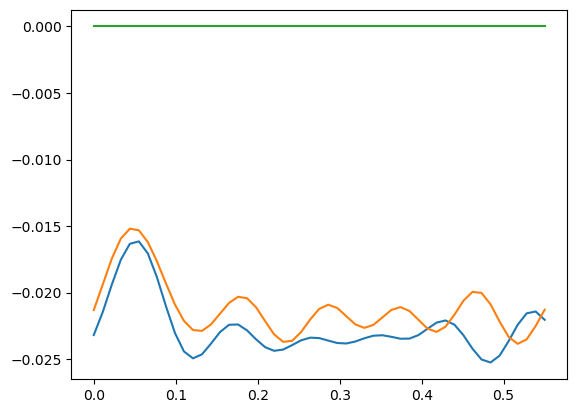

In [795]:
#
import time
t0=time.time()
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, 0.01658, Omega1, deltaxz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
print(time.time()-t0)
#Note: numba version only take 20 seconds for the simulation for 20000 molecules, 
#while the original version take about 137 seconds - numba version is 7x faster

plt.plot(tau,sig_p)
plt.plot(tau,sig_m)
plt.plot(tau,sig_c)
#plt.ylim([0, 1])

In [ ]:
t_pi

Text(0.5, 0, "$\\tau'(\\mu s)$")

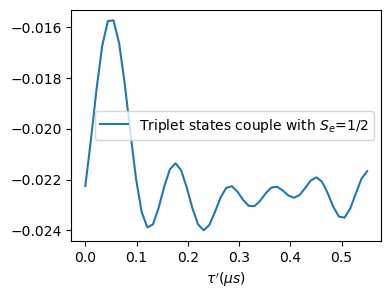

In [780]:
plt.figure(figsize=(4,3))
plt.plot(tau, (sig_p+sig_m)/2, label=r"Triplet states couple with ${S_e}$=1/2")
#plt.plot(tau, 1-sig_m, label=r"Triplet states couple with $m_{S_e}$=-1/2 state")
#plt.plot(tau, 1-sig_c, label=r"eYFP only (Spin $S_e$ removed)")
plt.legend()
plt.xlabel(r"$\tau'(\mu s)$")

## Using Stefan's DEERLab package to analyze the DEER data

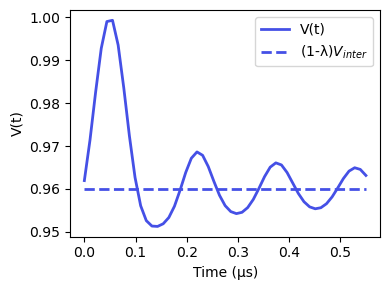

In [590]:
import deerlab as dl
@njit
def gamma_effective(B, D, E):
    p=p_function(B, D, E)
    q=2*D**3/27-2*D*E**2/3
    ang=np.arccos(3*q/(2*p)*np.sqrt(-3/p))/3
    return -2*28.02495142*B*np.cos(2*ang+np.pi*2/3)

@njit
def compute_fwhm(x, y):
    n = len(y)
    peak_index = 0
    peak_value = y[0]
    
    # Find peak manually
    for i in range(1, n):
        if y[i] > peak_value:
            peak_value = y[i]
            peak_index = i

    half_max = peak_value / 2.0

    # Search left side
    x_left = x[0]
    for i in range(peak_index, 0, -1):
        if y[i] < half_max and y[i+1] >= half_max:
            # linear interpolation
            x1 = x[i]
            x2 = x[i+1]
            y1 = y[i]
            y2 = y[i+1]
            x_left = x1 + (half_max - y1) * (x2 - x1) / (y2 - y1)
            break

    # Search right side
    x_right = x[-1]
    for i in range(peak_index, n - 1):
        if y[i] >= half_max and y[i+1] < half_max:
            # linear interpolation
            x1 = x[i]
            x2 = x[i+1]
            y1 = y[i]
            y2 = y[i+1]
            x_right = x1 + (half_max - y1) * (x2 - x1) / (y2 - y1)
            break

    fwhm = x_right - x_left
    return fwhm
    
# Simulation parameters
tau1, tau2 = 0.05, 0.5 # Inter-pulse delays, µs
tmin = 0.0            # Start time, μs
Δt = 0.011            # Time increment, μs

rmean = 2.0           # Mean distance, nm
rstd = 1e-3           # Distance standard deviation, nm
rmin, rmax = 1.5, 5   # Range of the distance vector, nm
Δr = 0.05             # Distance increment, nm

conc = 0             # Spin concentration, μM
lam = 0.040            # Modulation depth
V0 = 1                # Overall echo amplitude

# Time vector
tmax = tau1+tau2
t = np.arange(tmin, tmax, Δt)

# Distance vector
r = np.arange(rmin, rmax, Δr)

# Construct the 4-pulse DEER model
Vmodel = dl.dipolarmodel(t, r, Pmodel=dl.dd_gauss)

# Simulate the signal with orientation selection
Vsim = Vmodel(mean=rmean, std=rstd, conc=conc, scale=V0, mod=lam, reftime=tau1)

# Scaled background (for plotting)
Vinter = V0*(1-lam)*dl.bg_hom3d(t-tau1, conc, lam)

# Plot the simulated signal
violet = '#4550e6'
plt.figure(figsize=[4,3])
plt.plot(t, Vsim, color=violet, lw=2, label='V(t)')
plt.plot(t, Vinter, '--', color=violet, lw=2, label='(1-λ)$V_{inter}$')
plt.legend()
plt.xlabel('Time (μs)')
plt.ylabel('V(t)')
plt.tight_layout()
plt.show()


In [582]:
Vexp=(sig_p+sig_m)/2
Vexp = (Vexp-np.min(Vexp))/(np.max(Vexp)-np.min(Vexp))     # Rescaling (aesthetic)
t = t - t[0]                  # Account for zerotime
t = t + tmin    
# Distance vector
r = np.arange(1.5,3,0.002) # nm

# Construct the model
Vmodel = dl.dipolarmodel(t,r, experiment = dl.ex_4pdeer(tau1,tau2, pathways=[1,2, 3,4]))

# Fit the model to the data
results = dl.fit(Vmodel,Vexp)

# Print results summary
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.073         0.161             1.575          0.026  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.058            
Model parameters: 
=========== ======= ========================= ====== ====================================== 
 Parameter   Value   95%-Confidence interval   Unit   Description                           
=========== ======= ========================= ====== ====================================== 
 lam1        0.302   (0.00e+00,0.895)                 Amplitude of pathway #1               
 reftime1    0.065   (0.041,0.090)              μs    Refocusing time of pathway #1         
 lam2        0.315   (0.00e+00,1.000)                 Amplitude of pathwa

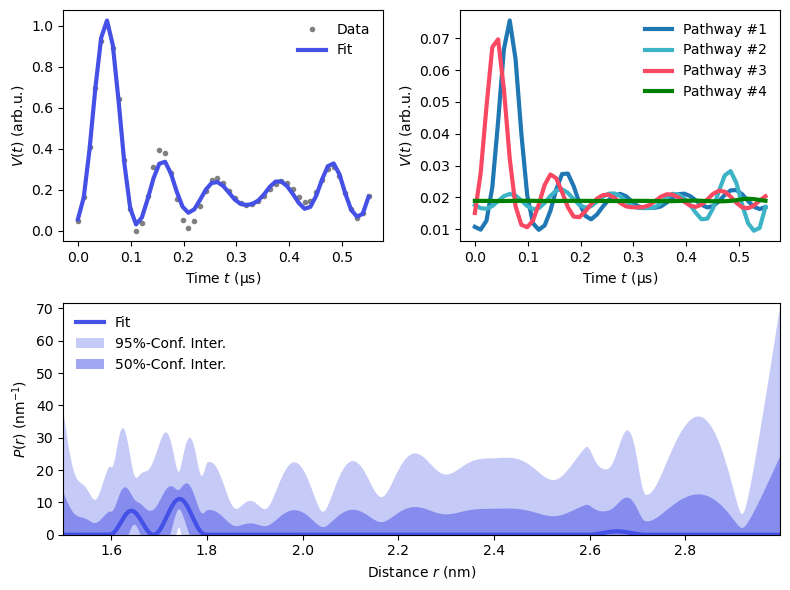

In [584]:
Vfit = results.model

# Extract fitted distance distribution
Pfit = results.P
Pci95 = results.PUncert.ci(95)
Pci50 = results.PUncert.ci(50)

plt.figure(figsize=[8,6])
violet = '#4550e6'
green = '#3cb4c6'
red = '#f84862'
plt.subplot(221)
# Plot experimental data
plt.plot(t,Vexp,'.',color='grey',label='Data')
# Plot the fitted signal
plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

plt.subplot(222)
lams = [results.lam1, results.lam2, results.lam3, results.lam4]
reftimes = [results.reftime1, results.reftime2, results.reftime3, results.reftime4]
colors= ['tab:blue',green, red, 'g']
Vinter = results.P_scale*(1-np.sum(lams))*np.prod([dl.bg_hom3d(t-reftime,results.conc,lam) for lam,reftime in zip(lams,reftimes)],axis=0)
for n,(lam,reftime,color) in enumerate(zip(lams,reftimes,colors)):
    Vpath = (1-np.sum(lams) + lam*dl.dipolarkernel(t-reftime,r)@Pfit)*Vinter
    plt.plot(t,Vpath,linewidth=3,label=f'Pathway #{n+1}',color=color)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

# Plot the distance distribution
plt.subplot(212)
plt.plot(r,Pfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')

plt.tight_layout()
plt.show()


In [586]:
#Measured distance d
r[np.argmax(Pfit)]

np.float64(1.7420000000000002)

In [660]:
d_ave=0.0
dr=r[1]-r[0]
for i in range(len(Pfit)):
    d_ave+=r[i]*Pfit[i]*dr
d_ave
#np.sum(Pfit)*dr

np.float64(1.7654430811444624)

In [664]:
d_std=0.0
dr=r[1]-r[0]
for i in range(len(Pfit)):
    d_std+=(r[i]-d_ave)**2*Pfit[i]*dr
np.sqrt(d_std)

np.float64(0.23446126044103335)

In [652]:
r = np.arange(1.5,3,0.002)

In [654]:
len(r)

750

In [662]:
#Data fitting for D
gamma_effective(0.03, 2.35, 0.47)**(1/3)*1.76

2.073323285628664

In [180]:
0.05*1.635**(1/3)

0.05890370195504349

In [311]:
compute_fwhm(r, Pfit)

(0.04366351093163079, 1.689419389508006, 1.7330829004396369)

## DEER on Tz-Ty transition

### Note: need to run another Rabi oscillation to determine the pi pulse duration for Tz-Ty transition

In [782]:
#t_pi=0.016582914572864322 #Note: need to run another Rabi oscillation to determine the pi pulse duration for Tz-Ty transition
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, 0.014, Omega1, deltayz, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)

Text(0.5, 0, "$\\tau'(\\mu s)$")

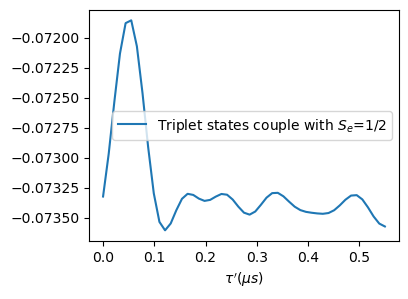

In [784]:
plt.figure(figsize=(4,3))
plt.plot(tau, (sig_p+sig_m)/2, label=r"Triplet states couple with ${S_e}$=1/2")
#plt.plot(tau, 1-sig_m, label=r"Triplet states couple with $m_{S_e}$=-1/2 state")
#plt.plot(tau, 1-sig_c, label=r"eYFP only (Spin $S_e$ removed)")
plt.legend()
plt.xlabel(r"$\tau'(\mu s)$")

In [766]:
#MW_linewidth=10 #MHz; we assume that we are driving the molecules with detuning less than 2 times of linewidth
N_mol = 20001 #Total molecule number
phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)
N_tau=51 #Time sequence resolution
tau_eyfp_1=0.05 #unit: us
tau_eyfp_2=0.5 #unit: us
tau_total=tau1+tau2
tau=np.linspace(0, tau_total, N_tau)
#theta_12 = 0 # Polar angle theta_12 is usually a fixed value for dumbbell model
#phi_12 = 0 # Set phi_12=0 for simplicity; but generally it is not)


V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d = 2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
#t_pi=0.011055 #Tz-Tx pi pulse duration, unit: us, the value is defined from the Rabi oscillation part of this jupyter notebook
t_pi=16.582914572864322 #Tz-Ty pi pulse duration
# Distance vector
r = np.arange(1.5,3,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))

N_mesh=100
theta_12_array=np.linspace(0, np.pi, N_mesh)
phi_12_array=np.linspace(0, 2*np.pi, N_mesh)

In [768]:
gamma_eff=np.zeros((N_mesh, N_mesh))
gamma_eff_unc=np.zeros((N_mesh, N_mesh))
all_result = [["" for _ in range(N_mesh)] for _ in range(N_mesh)]
sim_result = [["" for _ in range(N_mesh)] for _ in range(N_mesh)]
t0=time.time()
for i in range(N_mesh):
    for j in range(N_mesh):
        Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation(B0, D0, E0, d, Omega1, t_pi, phi_01, theta_01, chi_01, theta_12_array[i], phi_12_array[j])
        tau, sig_p, sig_m, sig_c = DEER_4_pulse_numba(Rabi_freq_yz, 0.014, Omega1, deltayz, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)
        sim_result[i][j] = [tau, sig_p, sig_m, sig_c]
        
        Vexp_0 = (sig_p + sig_m)/2
        Vexp = (Vexp_0-np.min(Vexp_0))/(np.max(Vexp_0)-np.min(Vexp_0))  
        results = dl.fit(Vmodel,Vexp)
        all_result[i][j] = results
        
        print(i, j, time.time()-t0, 's')
        #r_predict=np.max(Pfit)
        #gamma_eff[i, j]=(d/r_predict)**3
        #r_fwhm=compute_fwhm(r, Pfit)
        #gamma_eff_unc[i, j]=r_fwhm/2*gamma_eff[i, j]
        

0 0 36.53096890449524 s
0 1 71.05415034294128 s
0 2 106.18427729606628 s
0 3 140.4624662399292 s
0 4 175.57681941986084 s
0 5 211.66153502464294 s
0 6 245.5564501285553 s
0 7 285.09715032577515 s
0 8 321.8243525028229 s
0 9 357.3516192436218 s
0 10 392.19956517219543 s
0 11 425.27466082572937 s
0 12 459.67115235328674 s
0 13 493.8600010871887 s
0 14 531.9377400875092 s
0 15 568.0384557247162 s
0 16 602.2376153469086 s
0 17 648.1908414363861 s
0 18 685.3745620250702 s
0 19 722.7141752243042 s
0 20 759.6447260379791 s
0 21 795.4593493938446 s
0 22 831.8340437412262 s
0 23 868.3281235694885 s
0 24 902.7958650588989 s
0 25 940.4800517559052 s
0 26 976.4362945556641 s
0 27 1011.3407399654388 s
0 28 1046.4704985618591 s
0 29 1080.9367589950562 s
0 30 1116.8733551502228 s
0 31 1150.7735743522644 s
0 32 1185.0321519374847 s
0 33 1219.642008781433 s
0 34 1253.3955085277557 s
0 35 1287.507806301117 s
0 36 1320.405168056488 s
0 37 1353.882309436798 s
0 38 1386.9189410209656 s
0 39 1424.0253436565


KeyboardInterrupt



In [756]:
r_all=np.zeros((N_mesh, N_mesh))
r_all_unc=np.zeros((N_mesh, N_mesh))
D_eff_all=np.zeros((N_mesh, N_mesh))
dr=r[1]-r[0]
for i in range(N_mesh):
    for j in range(N_mesh):
        Pfit=all_result[i][j].P
        for r_i in range(len(r)):
            r_all[i][j]+=r[r_i]*Pfit[r_i]*dr
        D_eff_all[i][j]=(d/r_all[i][j])**3
for i in range(N_mesh):
    for j in range(N_mesh):
        Pfit=all_result[i][j].P
        for r_i in range(len(r)):
            r_all_unc[i][j]+=(r[r_i]-r_all[i][j])**2*Pfit[r_i]*dr

In [760]:
np.max(r_all_unc)

np.float64(0.5019952565280633)

In [748]:
import pickle

with open("fit_result.pkl", "wb") as f:
    pickle.dump(results, f) #Save the whole results as fit_result.pkl

In [752]:
with open("fit_result.pkl", "rb") as f:
    loaded_result = pickle.load(f) #Read the saved file and do not interrupt the type of the object

print(loaded_result)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.028         1.081             1.655          0.026  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.012            
Model parameters: 
=========== ========== ========================= ====== ====================================== 
 Parameter   Value      95%-Confidence interval   Unit   Description                           
=========== ========== ========================= ====== ====================================== 
 lam1        0.233      (0.179,0.288)                    Amplitude of pathway #1               
 reftime1    0.072      (0.067,0.077)              μs    Refocusing time of pathway #1         
 lam2        0.406      (0.236,0.577)                    A

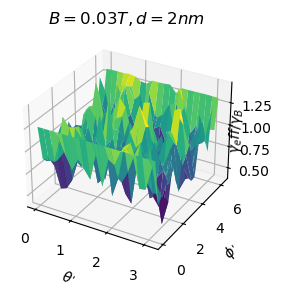

In [728]:
fig = plt.figure(figsize=(3,4))  # Create a figure
ax1 = fig.add_subplot(111, projection='3d')  # Add 3D axes
x, y = np.meshgrid(theta_12_array, phi_12_array)
ax1.set_title(r'$B=0.03T, d = 2nm$')
ax1.plot_surface(x,y, D_eff_all, cmap='viridis')
ax1.set_xlabel(r'$\theta^,$')
ax1.set_ylabel(r'$\phi^,$')
ax1.set_zlabel(r'$\gamma_eff/\gamma_B$', labelpad=-18)
ax1.zaxis.label.set_position((3, 6, 0))

In [754]:
with open("DEERLab_fitresult_grid_20-by-20.pkl", "wb") as f:
    pickle.dump(all_result, f)

In [764]:
simulation_configuration=[phi_01, theta_01, chi_01,Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz]
with open("DEERLab_simulation_configuration_20-by-20.pkl", "wb") as f:
    pickle.dump(simulation_configuration, f)

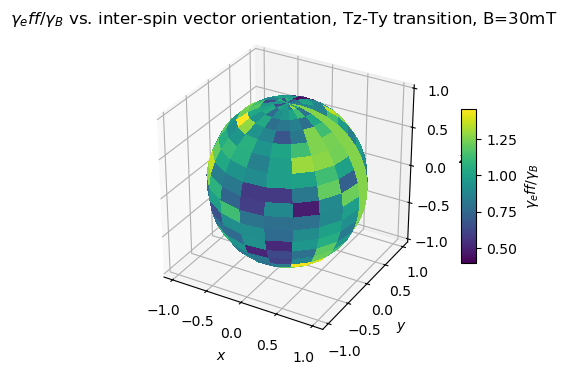

In [736]:
theta, phi = np.meshgrid(theta_12_array, phi_12_array)

# Step 2: Compute Cartesian coordinates for the unit sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)
F = D_eff_all
F_norm = (F - F.min()) / (F.max() - F.min())
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
#x,y,z=np.sin(theta_01)*np.cos(chi_01), np.sin(theta_01)*np.sin(chi_01), np.cos(theta_01), 
# Plot the surface and use the colormap to set face colors based on F_norm
surf = ax.plot_surface(
    x, y, z, 
    facecolors=plt.cm.viridis(F_norm), 
    rstride=1, cstride=1, 
    linewidth=0, antialiased=False, shade=False
)

# Step 4: Add a colorbar
mappable = ScalarMappable(cmap='viridis')
mappable.set_array(F)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label=r'$\gamma_eff/\gamma_B$')

# Setting labels and title
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_box_aspect([1,1,1])  # Ensure equal scaling

plt.title(r"$\gamma_eff/\gamma_B$ vs. inter-spin vector orientation, Tz-Ty transition, B=30mT")
plt.show()